In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
import pandas as pd
import glob
import yaml
from pathlib import Path


sys.path.append('../')


# Make sure this import is after pandas
import WireDAQ.PandasPlus

import WireDAQ.Constants as cst
import WireDAQ.NXCALS as nx
import WireDAQ.SigmaEff as sEff

import Utilities.plotter as MDplt
import Utilities.checker as MDchecks
# Matplotlib config
#============================
for key in plt.rcParams.keys():
    if 'date.auto' in key:
        plt.rcParams[key] = "%H:%M"
#============================
    

# Creating NXCALS variable containers
#============================
wires     = {'B1': [nx.NXCALSWire(loc = loc) for loc in ['L1B1','L5B1']],
             'B2': [nx.NXCALSWire(loc = loc) for loc in ['R1B2','R5B2']]}
beams     = [nx.NXCALSBeam(name) for name in ['B1','B2']]
buckets   = np.arange(3564)
#============================


with open('config.yaml','r') as fid:
    configuration = yaml.safe_load(fid)

TZONE = configuration['time_zone']




# Loading filling pattern with extra train info
patt = sEff.getFillingPattern('Utilities/MD8043_filling.json')

%matplotlib widget

Computing collision schedules...
Done Beam 1
Done Beam 2


---
# Load database if needed
---

In [25]:
if True:
    # Finding last file and importing data
    parquet_path = Path(configuration['parquet_path'])
    filePool = sorted(list(parquet_path.glob('*')))
    database = sEff.import_MD_Data(filePool[-1])

    # Taking subset defined in the config
    if configuration['stop_ts'] == 'None':
        configuration['stop_ts'] = str(database['Timestamp'].max()).split('+')[0]

    database = database[(pd.Timestamp(configuration['start_ts'],tz=TZONE)<database['Timestamp'])&
                    (pd.Timestamp(configuration['stop_ts'],tz=TZONE)>database['Timestamp'])]
    #============================


    # Analysis
    #============================



    # Computing intensity avg (every 20 seconds) with calibration BCT_A+BCT_B
    BCT_avg  = sEff.compute_BCT_avg(database,configuration)
    database = pd.concat([database,BCT_avg])
    database = database.sort_index()

    # Computing Lumi tot (ATLAS + CMS bunch by bunch)
    Lumi_tot = sEff.computeLumiTot(database)
    database = pd.concat([database,Lumi_tot])
    database = database.sort_index()

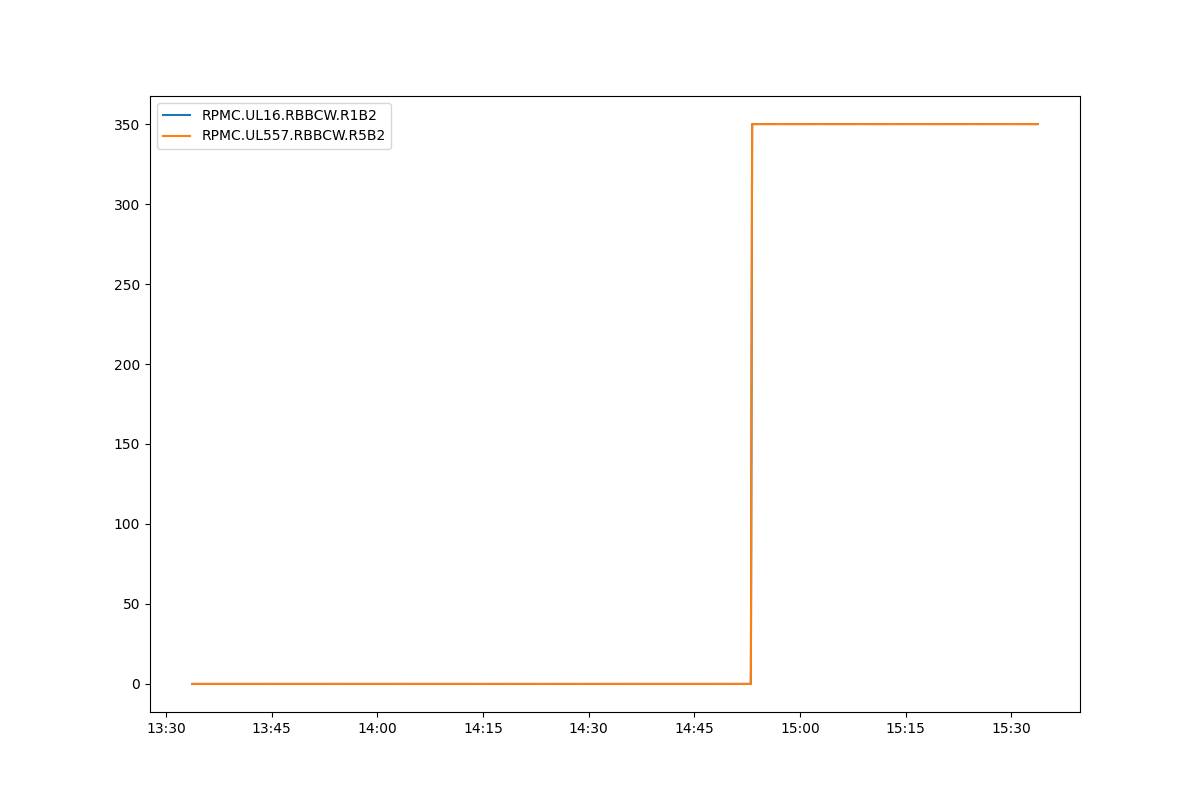

In [26]:
plt.figure(figsize=(12,8))
for wire in wires['B2']:
    database.nxPlot('Timestamp',wire.I,label=wire.name)
plt.legend()

---
# Load xsection dfs
---

In [21]:

# Loading effective cross section df
#-----------------------------------
xsection_df = {}
xsection_smooth_df = {}
for beam in beams:
    df_path = configuration['analysis_path'] + f'/{beam.name}/xsection/'
    
    filePool = sorted(list(Path(df_path).glob('xsection_2*')))
    xsection_df[beam.name] = pd.read_pickle(filePool[-1])

    filePool = sorted(list(Path(df_path).glob('xsection_smooth_2*')))
    xsection_smooth_df[beam.name] = pd.read_pickle(filePool[-1])
#-----------------------------------

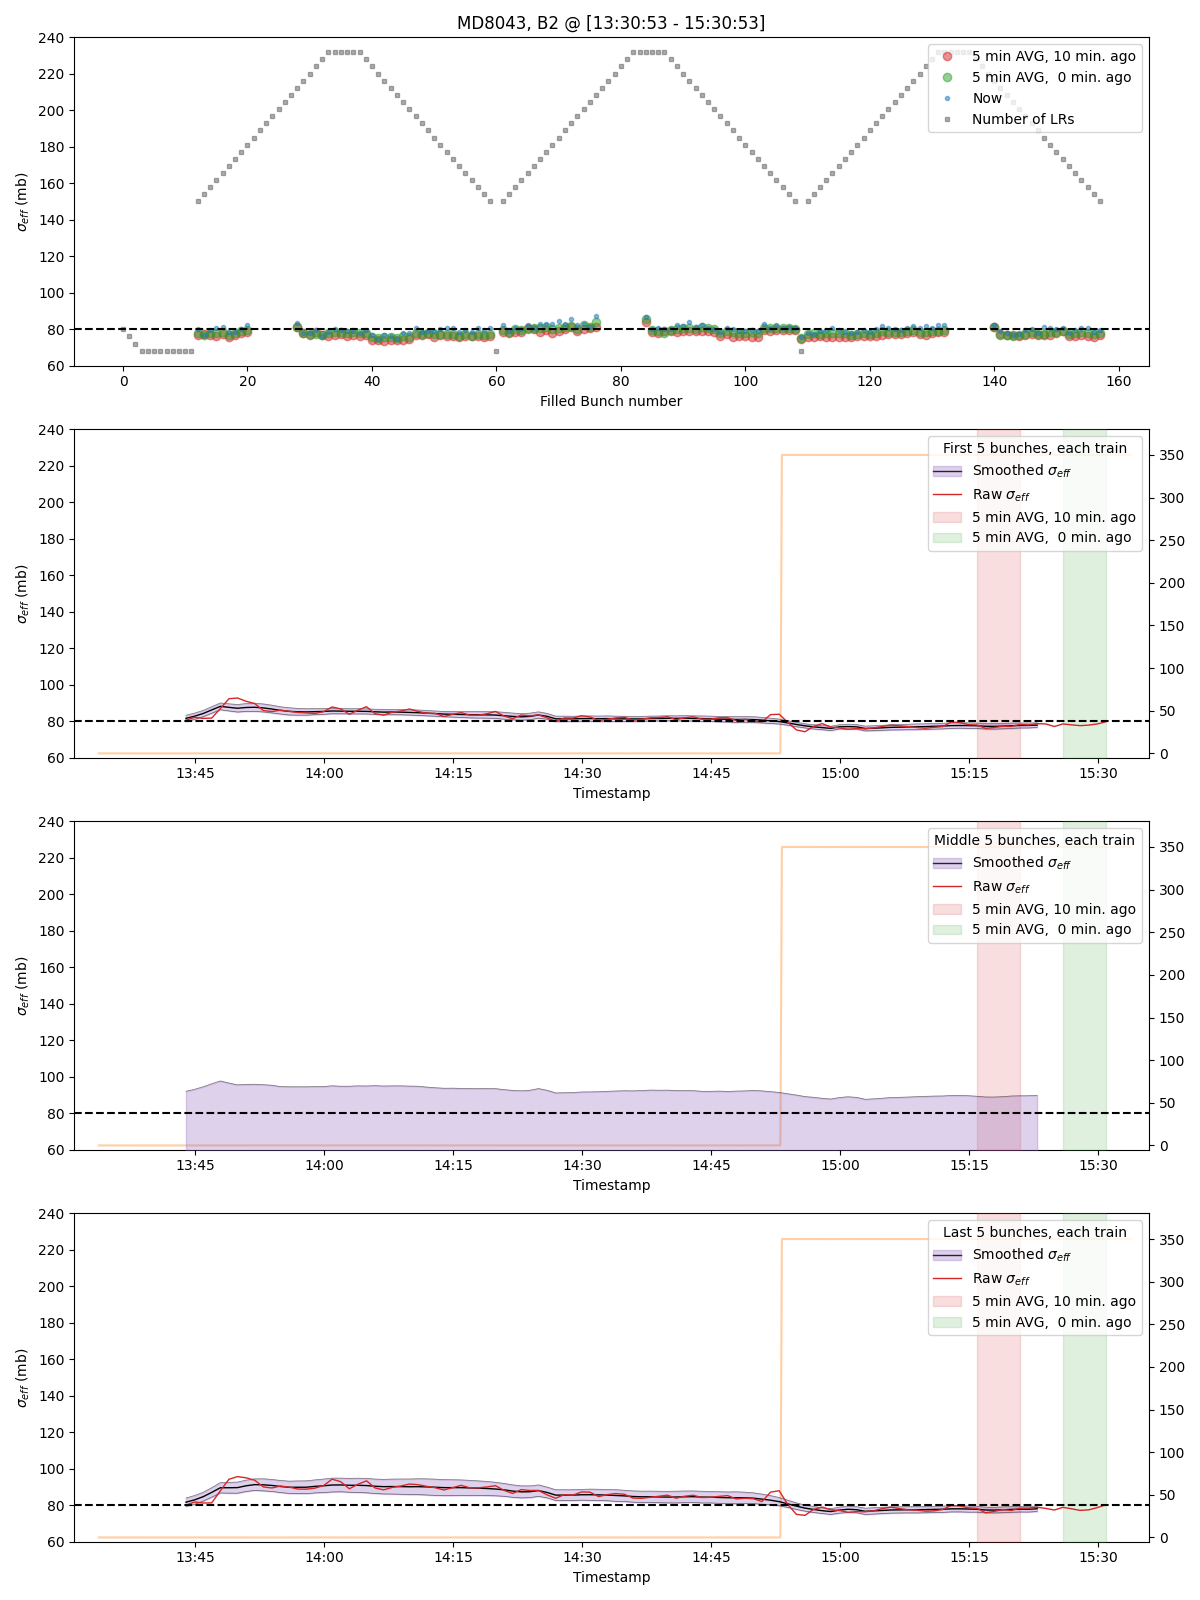

In [24]:
MDplt.plot_001_wire(database,xsection_df,xsection_smooth_df,'B2',patt,configuration)